# NOTEBOOK 5: COLLABORATIVE FILTERING

## User-Based and Item-Based Recommendation Systems

This notebook builds the foundation for collaborative filtering by creating the user-item interaction matrix.
Future enhancements will include similarity computations and recommendation generation.

## 1. SETUP & CONFIGURATION

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import warnings
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import time


warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("=" * 80)
print("COLLABORATIVE FILTERING RECOMMENDATION SYSTEM")
print("=" * 80)
print(f" Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f" Goal: Build user-based and item-based collaborative filtering")
print("=" * 80)

COLLABORATIVE FILTERING RECOMMENDATION SYSTEM
 Started: 2025-11-16 12:19:38
 Goal: Build user-based and item-based collaborative filtering


## 2. DATA LOADING & PREPARATION

In [10]:
print("\n" + "=" * 80)
print("LOADING DATA")
print("=" * 80)

# Define paths
BASE_DIR = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) == 'notebooks' else os.getcwd()
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
RESULTS_DIR = os.path.join(BASE_DIR, 'reports', 'results')

# Create directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"\nData directory: {PROCESSED_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Results directory: {RESULTS_DIR}")

# Load datasets with error handling
print("\nLoading datasets...")
try:
    movies = pd.read_csv(os.path.join(PROCESSED_DIR, 'movies_features.csv'))
    train = pd.read_csv(os.path.join(PROCESSED_DIR, 'train.csv'))
    test = pd.read_csv(os.path.join(PROCESSED_DIR, 'test.csv'))
    print("✅ Data loaded successfully")
except FileNotFoundError as e:
    print(f"❌ Error: File not found - {e}")
    raise
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

# Data validation
print("\n🔍 Validating data...")
if train.empty or test.empty or movies.empty:
    raise ValueError("One or more datasets are empty")
if train['rating'].isnull().any() or test['rating'].isnull().any():
    raise ValueError("Ratings contain NaN values")
if not all(col in train.columns for col in ['userId', 'movieId', 'rating']):
    raise ValueError("Training data missing required columns")
if not all(col in test.columns for col in ['userId', 'movieId', 'rating']):
    raise ValueError("Test data missing required columns")
print("✅ Data validation passed")


LOADING DATA

Data directory: c:\Users\mhfou\Documents\MovieRecommenderSystem\data\processed
Models directory: c:\Users\mhfou\Documents\MovieRecommenderSystem\models
Results directory: c:\Users\mhfou\Documents\MovieRecommenderSystem\reports\results

Loading datasets...
✅ Data loaded successfully

🔍 Validating data...
✅ Data validation passed


## 3. DATASET SUMMARY


DATASET SUMMARY

📊 Training Set:
   Ratings: 20,000,076
   Users: 137,883
   Movies: 34,461
   Avg ratings per user: 145.1
   Avg ratings per movie: 580.4

📊 Test Set:
   Ratings: 5,000,019
   Users: 31,059
   Movies: 55,199

🎬 Movies:
   Total movies: 62,423
   With ratings: 62,423

⭐ Rating Distribution (Training):
   0.5:   275,966 ( 1.38%)
   1.0: █  658,943 ( 3.29%)
   1.5:   293,763 ( 1.47%)
   2.0: ███ 1,387,916 ( 6.94%)
   2.5: ██  930,399 ( 4.65%)
   3.0: ██████████ 4,146,639 (20.73%)
   3.5: █████ 2,325,357 (11.63%)
   4.0: █████████████ 5,470,576 (27.35%)
   4.5: ████ 1,612,827 ( 8.06%)
   5.0: ███████ 2,897,690 (14.49%)

📊 Creating rating distribution visualization...
   ✅ Saved: rating_distribution_cf.png


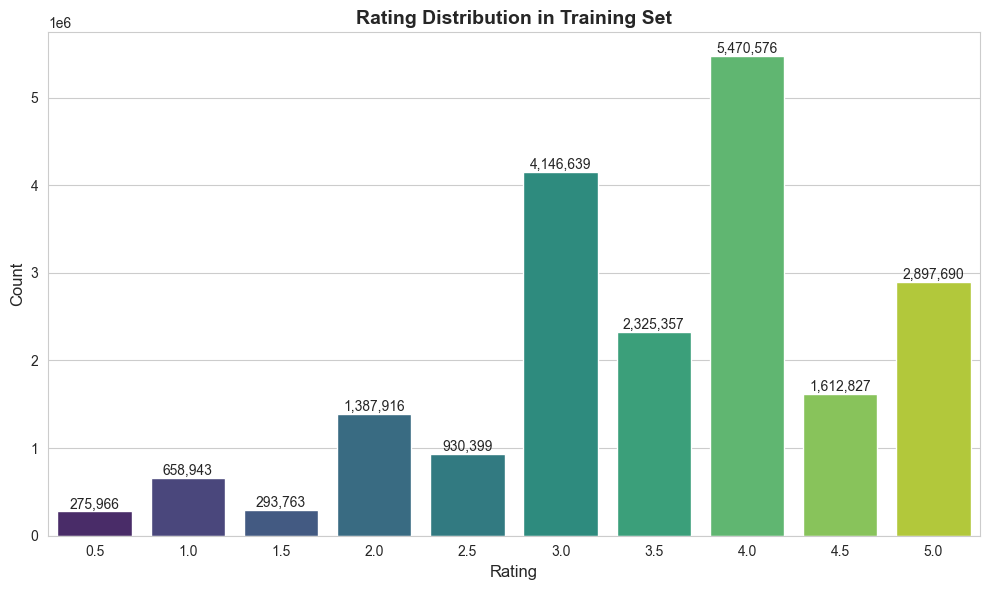

In [11]:
print("\n" + "=" * 80)
print("DATASET SUMMARY")
print("=" * 80)

print(f"\n📊 Training Set:")
print(f"   Ratings: {len(train):,}")
print(f"   Users: {train['userId'].nunique():,}")
print(f"   Movies: {train['movieId'].nunique():,}")
print(f"   Avg ratings per user: {len(train)/train['userId'].nunique():.1f}")
print(f"   Avg ratings per movie: {len(train)/train['movieId'].nunique():.1f}")

print(f"\n📊 Test Set:")
print(f"   Ratings: {len(test):,}")
print(f"   Users: {test['userId'].nunique():,}")
print(f"   Movies: {test['movieId'].nunique():,}")

print(f"\n🎬 Movies:")
print(f"   Total movies: {len(movies):,}")
print(f"   With ratings: {movies['rating_count'].notna().sum():,}")

# Rating distribution
print(f"\n⭐ Rating Distribution (Training):")
rating_dist = train['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    percentage = (count / len(train)) * 100
    bar = '█' * int(percentage / 2)
    print(f"   {rating:.1f}: {bar} {count:>8,} ({percentage:>5.2f}%)")
    #                                    ↑ Fixed: width then comma

# Visualization: Rating distribution
print(f"\n📊 Creating rating distribution visualization...")

plt.figure(figsize=(10, 6))
sns.barplot(x=rating_dist.index, y=rating_dist.values, palette='viridis')
plt.title('Rating Distribution in Training Set', fontsize=14, fontweight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

# Add count labels on bars
for i, (rating, count) in enumerate(rating_dist.items()):
    plt.text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, 'rating_distribution_cf.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: {os.path.basename(viz_path)}")

plt.show()

print("\n" + "=" * 80)

## 4. USER-ITEM INTERACTION MATRIX


BUILDING USER-ITEM INTERACTION MATRIX

🔧 Creating sparse matrix from ratings...
   This is the core data structure for collaborative filtering

📋 Step 1: Create ID mappings
   ✅ User mapping: 137,883 users
   ✅ Movie mapping: 34,461 movies

📋 Step 2: Convert IDs to matrix indices
   ✅ Converted 20,000,076 ratings

📋 Step 3: Build sparse matrix
   Using CSR (Compressed Sparse Row) format for efficient row operations

✅ Matrix created successfully!

📊 Matrix Statistics:
   Shape: 137,883 users × 34,461 movies
   Total cells: 4,751,586,063
   Non-zero ratings: 20,000,076
   Sparsity: 99.58%
   Memory usage: 152.59 MB

📈 Rating Density:
   Ratings per user:
      Mean: 145.1
      Median: 68.0
      Min: 1
      Max: 12097
   Ratings per movie:
      Mean: 580.4
      Median: 9.0
      Min: 1
      Max: 67782

📊 Creating visualizations...
   ✅ Saved: 01_matrix_density_analysis.png


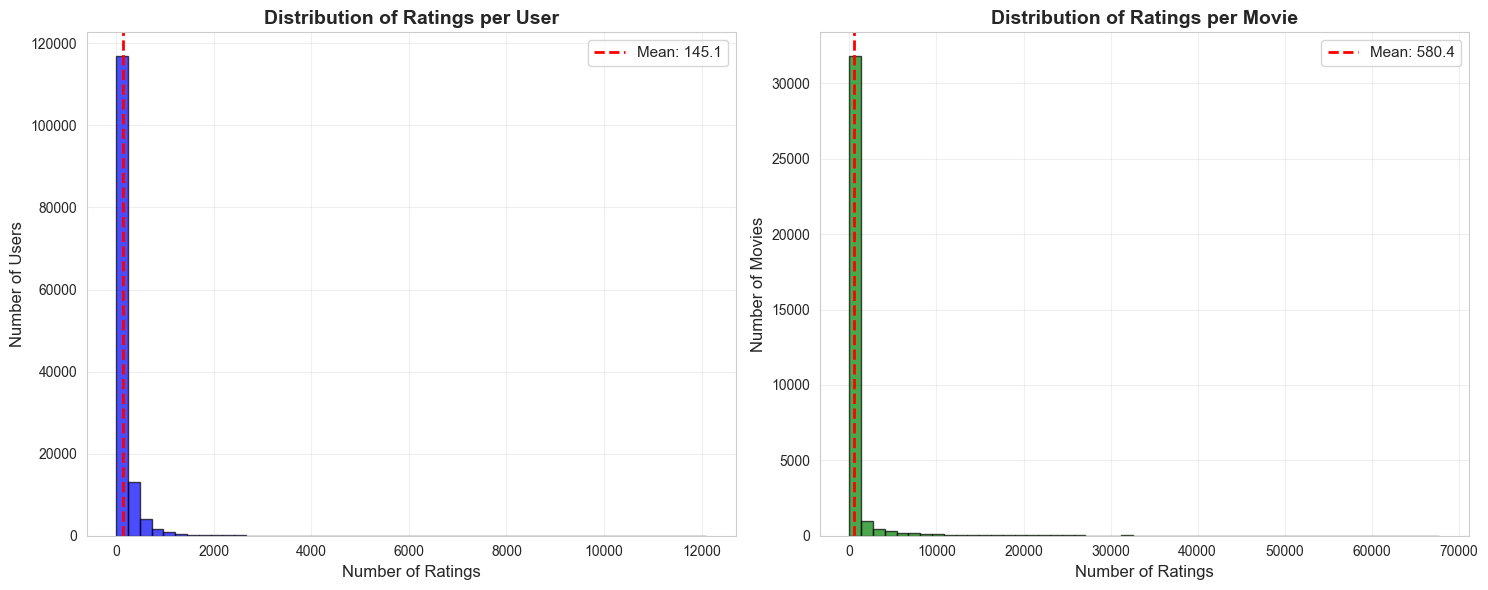


📋 Step 4: Save matrix and mappings
   ✅ Saved: user_item_matrix.npz (39.46 MB)
   ✅ Saved: user_item_matrix.pkl (229.41 MB)
   ✅ Saved: matrix_mappings.pkl

✅ Cell 4 complete!


In [12]:
print("\n" + "=" * 80)
print("BUILDING USER-ITEM INTERACTION MATRIX")
print("=" * 80)

print("\n🔧 Creating sparse matrix from ratings...")
print("   This is the core data structure for collaborative filtering")

# Create user and movie mappings
print("\n📋 Step 1: Create ID mappings")

unique_users = train['userId'].unique()
unique_movies = train['movieId'].unique()

user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}

movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}
idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}

print(f"   ✅ User mapping: {len(user_to_idx):,} users")
print(f"   ✅ Movie mapping: {len(movie_to_idx):,} movies")

# Convert train data to matrix indices
print("\n📋 Step 2: Convert IDs to matrix indices")
train_users = train['userId'].map(user_to_idx).values
train_movies = train['movieId'].map(movie_to_idx).values
train_ratings = train['rating'].values

print(f"   ✅ Converted {len(train_ratings):,} ratings")

# Create sparse matrix
print("\n📋 Step 3: Build sparse matrix")
print("   Using CSR (Compressed Sparse Row) format for efficient row operations")

user_item_matrix = csr_matrix(
    (train_ratings, (train_users, train_movies)),
    shape=(len(unique_users), len(unique_movies))
)

print(f"\n✅ Matrix created successfully!")
print(f"\n📊 Matrix Statistics:")
print(f"   Shape: {user_item_matrix.shape[0]:,} users × {user_item_matrix.shape[1]:,} movies")
print(f"   Total cells: {user_item_matrix.shape[0] * user_item_matrix.shape[1]:,}")
print(f"   Non-zero ratings: {user_item_matrix.nnz:,}")
print(f"   Sparsity: {(1 - user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.2f}%")
print(f"   Memory usage: {user_item_matrix.data.nbytes / (1024**2):.2f} MB")

# Calculate density statistics
print(f"\n📈 Rating Density:")
ratings_per_user = np.diff(user_item_matrix.indptr)
ratings_per_movie = np.asarray((user_item_matrix > 0).sum(axis=0)).flatten()

print(f"   Ratings per user:")
print(f"      Mean: {ratings_per_user.mean():.1f}")
print(f"      Median: {np.median(ratings_per_user):.1f}")
print(f"      Min: {ratings_per_user.min()}")
print(f"      Max: {ratings_per_user.max()}")

print(f"   Ratings per movie:")
print(f"      Mean: {ratings_per_movie.mean():.1f}")
print(f"      Median: {np.median(ratings_per_movie):.1f}")
print(f"      Min: {ratings_per_movie.min()}")
print(f"      Max: {ratings_per_movie.max()}")

# Visualizations
print(f"\n📊 Creating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Ratings per user distribution
axes[0].hist(ratings_per_user, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Distribution of Ratings per User', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Ratings', fontsize=12)
axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].axvline(ratings_per_user.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {ratings_per_user.mean():.1f}')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Ratings per movie distribution
axes[1].hist(ratings_per_movie, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Distribution of Ratings per Movie', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Ratings', fontsize=12)
axes[1].set_ylabel('Number of Movies', fontsize=12)
axes[1].axvline(ratings_per_movie.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {ratings_per_movie.mean():.1f}')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()

# Save figure
viz_path = os.path.join(RESULTS_DIR, '01_matrix_density_analysis.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: {os.path.basename(viz_path)}")

plt.show()

# =============================================================================
# STEP 4: Save Matrix and Mappings
# =============================================================================
print("\n📋 Step 4: Save matrix and mappings")

from scipy.sparse import save_npz

# Save sparse matrix (compressed format)
matrix_npz_path = os.path.join(MODELS_DIR, 'user_item_matrix.npz')
save_npz(matrix_npz_path, user_item_matrix)
print(f"   ✅ Saved: user_item_matrix.npz ({os.path.getsize(matrix_npz_path) / (1024**2):.2f} MB)")

# Save as pickle (backup)
matrix_pkl_path = os.path.join(MODELS_DIR, 'user_item_matrix.pkl')
with open(matrix_pkl_path, 'wb') as f:
    pickle.dump(user_item_matrix, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"   ✅ Saved: user_item_matrix.pkl ({os.path.getsize(matrix_pkl_path) / (1024**2):.2f} MB)")

# Save mappings
mappings = {
    'user_to_idx': user_to_idx,
    'movie_to_idx': movie_to_idx,
    'idx_to_user': idx_to_user,
    'idx_to_movie': idx_to_movie,
    'n_users': len(unique_users),
    'n_movies': len(unique_movies),
    'n_ratings': user_item_matrix.nnz,
    'sparsity': (1 - user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100
}

mappings_path = os.path.join(MODELS_DIR, 'matrix_mappings.pkl')
with open(mappings_path, 'wb') as f:
    pickle.dump(mappings, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"   ✅ Saved: matrix_mappings.pkl")

print("\n✅ Cell 4 complete!")
print("=" * 80)


In [5]:
print("\nTrain data after mapping (first 5 rows):")
mapped_sample = pd.DataFrame({
    'userId': train['userId'].head().values,
    'movieId': train['movieId'].head().values,
    'user_idx': train['userId'].head().map(user_to_idx).values,
    'movie_idx': train['movieId'].head().map(movie_to_idx).values,
    'rating': train['rating'].head().values
})
mapped_sample.head()


Train data after mapping (first 5 rows):


,userId,movieId,user_idx,movie_idx,rating
0,2262,21,0,0,3.0
1,2262,47,0,1,5.0
2,2262,1079,0,2,3.0
3,124805,21,1,0,5.0
4,102689,32,2,3,5.0


## 5. USER-BASED COLLABORATIVE FILTERING 


## 5.1 Building the User–User Similarity Matrix


USER-BASED COLLABORATIVE FILTERING (Demo / Presentation)

📊 Using sampling strategy for demonstration
   Sampling 5,000 most active users

✅ Sampled matrix shape: (5000, 34461)

Sample of user-item ratings (first 5 users × 5 items):
[[0.  4.5 3.5 4.5 0. ]
 [4.  4.5 5.  0.  4. ]
 [2.  4.  4.  3.  0. ]
 [0.  0.  3.5 0.  0. ]
 [3.5 3.5 4.  3.5 0. ]]

⏳ Computing cosine similarity between users...
✅ Similarity computation complete in 22.5 sec

Sample user-user similarity (first 5 users × 5 users):
[[0.    0.445 0.464 0.29  0.385]
 [0.445 0.    0.322 0.276 0.34 ]
 [0.464 0.322 0.    0.329 0.331]
 [0.29  0.276 0.329 0.    0.169]
 [0.385 0.34  0.331 0.169 0.   ]]

Similarity Statistics:
  Min similarity: 0.0000
  Max similarity: 0.9817
  Mean similarity (non-zero): 0.3133
  Median similarity (non-zero): 0.3156
  Std deviation (non-zero): 0.0924

Similarity Sparsity:
  Zero similarities: 5,148 (0.0%)
  Non-zero similarities: 24,994,852 (100.0%)

✅ Saved heatmap: c:\Users\mhfou\Documents\Movie

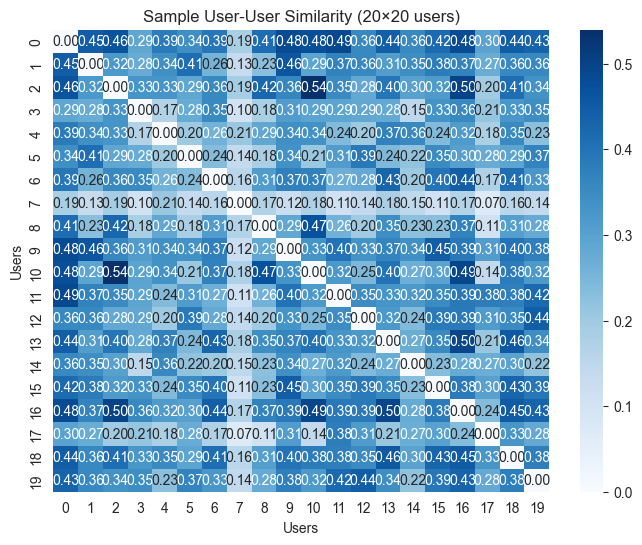


💡 Interpretation:
  High average similarity → Strong user agreement
  Favorable for collaborative filtering


--------------------------------------------------------------------------------
STEP 6: Saving User Similarity Matrix
--------------------------------------------------------------------------------
✅ Saved: user_similarity_sampled.npy
   Shape: (5000, 5000)
   Size: 190.73 MB
✅ Saved: sampled_users_idx.npy

✅ User similarity matrix saved successfully!


In [14]:
print("\n" + "=" * 80)
print("USER-BASED COLLABORATIVE FILTERING (Demo / Presentation)")
print("=" * 80)

# =============================================================================
# STEP 1: Sample Users 
# =============================================================================
SAMPLE_USERS = True
SAMPLE_SIZE = 5000  

if SAMPLE_USERS:
    print("\n📊 Using sampling strategy for demonstration")
    print(f"   Sampling {SAMPLE_SIZE:,} most active users")
    
    user_activity = np.array(user_item_matrix.getnnz(axis=1))
    top_users_idx = np.argsort(user_activity)[-SAMPLE_SIZE:]
    user_matrix_subset = user_item_matrix[top_users_idx]
    print(f"\n✅ Sampled matrix shape: {user_matrix_subset.shape}")
else:
    user_matrix_subset = user_item_matrix
    top_users_idx = np.arange(user_item_matrix.shape[0])
    print("\n🚀 Using full user matrix (may be slow)")

# Show a small portion of user-item matrix for clarity
print("\nSample of user-item ratings (first 5 users × 5 items):")
print(user_matrix_subset[:5, :5].toarray())

# =============================================================================
# STEP 2: Compute User-User Similarity
# =============================================================================
print("\n⏳ Computing cosine similarity between users...")
start_time = time.time()
user_similarity = cosine_similarity(user_matrix_subset, dense_output=True)
elapsed_time = time.time() - start_time
print(f"✅ Similarity computation complete in {elapsed_time:.1f} sec")

# Set self-similarity to 0 for clarity
np.fill_diagonal(user_similarity, 0)

# Show a small similarity sample
print("\nSample user-user similarity (first 5 users × 5 users):")
print(np.round(user_similarity[:5, :5], 3))

# =============================================================================
# STEP 3: Analyze Similarity Distribution
# =============================================================================
non_zero_sims = user_similarity[user_similarity > 0]

print("\nSimilarity Statistics:")
print(f"  Min similarity: {user_similarity.min():.4f}")
print(f"  Max similarity: {user_similarity.max():.4f}")
print(f"  Mean similarity (non-zero): {non_zero_sims.mean():.4f}")
print(f"  Median similarity (non-zero): {np.median(non_zero_sims):.4f}")
print(f"  Std deviation (non-zero): {non_zero_sims.std():.4f}")

# Sparsity
zero_sims = (user_similarity == 0).sum()
total_comparisons = user_similarity.size
print(f"\nSimilarity Sparsity:")
print(f"  Zero similarities: {zero_sims:,} ({zero_sims/total_comparisons*100:.1f}%)")
print(f"  Non-zero similarities: {total_comparisons - zero_sims:,} ({(total_comparisons-zero_sims)/total_comparisons*100:.1f}%)")

# =============================================================================
# STEP 4: Visualize Similarity 
# =============================================================================
plt.figure(figsize=(8,6))
sns.heatmap(user_similarity[:20, :20], annot=True, fmt=".2f", cmap="Blues")
plt.title("Sample User-User Similarity (20×20 users)")
plt.xlabel("Users")
plt.ylabel("Users")

# Save the figure BEFORE showing
heatmap_path = os.path.join(RESULTS_DIR, '02_user_similarity_heatmap.png')
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Saved heatmap: {heatmap_path}")

plt.show()  # Then show it

# =============================================================================
# STEP 5: Interpretation
# =============================================================================
print("\n💡 Interpretation:")
if non_zero_sims.mean() < 0.1:
    print("  Low average similarity → Users have diverse tastes")
    print("  Recommendation challenge: Few highly similar users")
elif non_zero_sims.mean() < 0.3:
    print("  Moderate similarity → Reasonable user overlap")
    print("  Good balance for collaborative filtering")
else:
    print("  High average similarity → Strong user agreement")
    print("  Favorable for collaborative filtering")

print("\n" + "=" * 80)

# =============================================================================
# STEP 6: Save User Similarity Matrix
# =============================================================================
print("\n" + "-" * 80)
print("STEP 6: Saving User Similarity Matrix")
print("-" * 80)

import pickle
from scipy.sparse import save_npz, csr_matrix

# Save as numpy array (for sampled users)
similarity_path = os.path.join(MODELS_DIR, 'user_similarity_sampled.npy')
np.save(similarity_path, user_similarity)
print(f"✅ Saved: {os.path.basename(similarity_path)}")
print(f"   Shape: {user_similarity.shape}")
print(f"   Size: {os.path.getsize(similarity_path) / (1024**2):.2f} MB")

# Save the indices of sampled users
sampled_users_path = os.path.join(MODELS_DIR, 'sampled_users_idx.npy')
np.save(sampled_users_path, top_users_idx)
print(f"✅ Saved: {os.path.basename(sampled_users_path)}")

print("\n✅ User similarity matrix saved successfully!")


## 5.2 USER-BASED RECOMMENDATION FUNCTION


In [ ]:
print("\n" + "=" * 80)
print("USER-BASED COLLABORATIVE FILTERING")
print("=" * 80)

# ---------------------------------------------------------------------
# STEP 1 — Recommendation Function
# ---------------------------------------------------------------------

def recommend_user_based(user_id, n_recommendations=10, min_similarity=0.3, min_neighbors=3):
    """
    Generate movie recommendations using USER-BASED Collaborative Filtering.
    
    Steps:
      1. Find similar users (similarity ≥ min_similarity)
      2. For each unrated movie:
            - Collect ratings from similar users
            - Compute weighted average (similarity × rating)
      3. Rank movies by predicted rating

    Parameters:
        user_id (int) : Target user
        n_recommendations (int) : Number of movies to return
        min_similarity (float) : Similarity threshold
        min_neighbors (int) : Minimum similar users who rated the movie

    Returns:
        DataFrame containing:
            rank, movieId, predicted_rating, n_neighbors,
            avg_neighbor_similarity, title, genres, etc.
    """

    # Check that user exists
    if user_id not in user_to_idx:
        return f"❌ User {user_id} not found in training set"

    user_idx = user_to_idx[user_id]

    # User must exist in sampled matrix
    if user_idx not in top_users_idx:
        return f"⚠️ User {user_id} not in sampled set (use item-based fallback)"

    # Position within sampled similarity matrix
    sampled_pos = np.where(top_users_idx == user_idx)[0][0]

    # User's rating vector
    user_ratings = user_item_matrix[user_idx].toarray().flatten()

    # Similarities to all sampled users
    sims = user_similarity[sampled_pos]

    # Users above threshold
    mask_similar = sims >= min_similarity
    similar_users = top_users_idx[mask_similar]
    similar_sims = sims[mask_similar]

    if len(similar_users) == 0:
        return f"❌ No similar users found (similarity ≥ {min_similarity})"

    # Movies user has not rated
    unrated_indices = np.where(user_ratings == 0)[0]
    predictions = []

    for movie_idx in unrated_indices:
        ratings_from_neighbors = (
            user_item_matrix[similar_users, movie_idx].toarray().flatten()
        )

        rated_mask = ratings_from_neighbors > 0
        if rated_mask.sum() < min_neighbors:
            continue

        sims_used = similar_sims[rated_mask]
        ratings_used = ratings_from_neighbors[rated_mask]

        predicted = np.sum(sims_used * ratings_used) / np.sum(sims_used)
        movie_id = idx_to_movie[movie_idx]

        predictions.append({
            'movieId': movie_id,
            'predicted_rating': predicted,
            'n_neighbors': int(rated_mask.sum()),
            'avg_neighbor_similarity': float(sims_used.mean()),
        })

    if not predictions:
        return "❌ No predictions possible for this user."

    # Build results
    df = pd.DataFrame(predictions)
    df = df.sort_values('predicted_rating', ascending=False).head(n_recommendations)

    # Add movie metadata
    df = df.merge(
        movies[['movieId', 'title', 'genres', 'release_year', 
                'rating_mean', 'rating_count']],
        on='movieId',
        how='left'
    )

    df.insert(0, 'rank', range(1, len(df) + 1))
    df['predicted_rating'] = df['predicted_rating'].round(2)

    return df


print("✅ Function created: recommend_user_based()")


# ---------------------------------------------------------------------
# STEP 2 — Quick Test on 1 Random User
# ---------------------------------------------------------------------

np.random.seed(42)
test_user_global_idx = np.random.choice(top_users_idx)
test_user_id = idx_to_user[test_user_global_idx]

print("\nTesting on random user:", test_user_id)

recs = recommend_user_based(test_user_id, n_recommendations=10)

if isinstance(recs, str):
    print(recs)
else:
    print("\nTop Recommendations:")
    display(recs[['rank', 'title', 'predicted_rating', 
                  'n_neighbors', 'avg_neighbor_similarity']])

print("\n" + "=" * 80)
print("USER-BASED CF — COMPLETE")
print("=" * 80)



USER-BASED COLLABORATIVE FILTERING
✅ Function created: recommend_user_based()

Testing on random user: 25686


## 6. ITEM-BASED COLLABORATIVE FILTERING


ITEM-BASED COLLABORATIVE FILTERING

--------------------------------------------------------------------------------
APPROACH: Item-Based Collaborative Filtering
--------------------------------------------------------------------------------

Core Idea: "People who liked this item also liked..."

How it differs from User-Based:
- User-Based: Find similar USERS, recommend what THEY liked
- Item-Based: Find similar ITEMS, recommend SIMILAR items

Example:
  User liked: The Matrix
  System finds: Movies similar to The Matrix (based on co-ratings)
  Recommends: Inception, Blade Runner (rated similarly by same users)

Advantages over User-Based:
✅ More stable (item similarities change slowly)
✅ Better explainability ("Because you watched X...")
✅ Often better performance in practice
✅ Used by Amazon, Netflix, YouTube

Key Difference:
- User similarity: Based on rating PATTERNS across items
- Item similarity: Based on being rated SIMILARLY by same users


----------------------------------

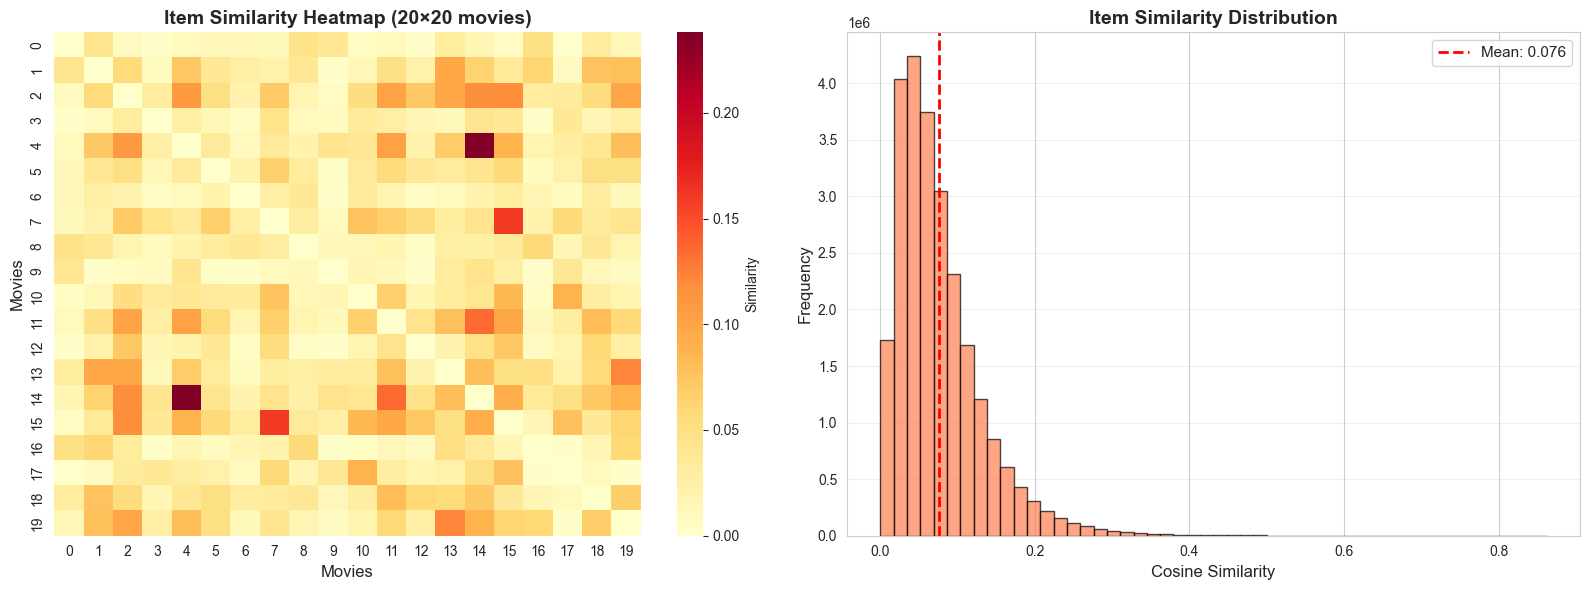


--------------------------------------------------------------------------------
STEP 5: User vs Item Similarity Comparison
--------------------------------------------------------------------------------

Comparison:
Metric                         User Similarity      Item Similarity     
----------------------------------------------------------------------
Mean similarity                0.3133               0.0759              
Median similarity              0.3156               0.0629              
Std deviation                  0.0924               0.0554              
Sparsity (%)                   0.0                  0.0                 

💡 Interpretation:
   User similarities are HIGHER on average than item similarities
   → Users have more consistent preferences
   → User-based CF may perform better

--------------------------------------------------------------------------------
STEP 6: Saving Item Similarity Matrix
----------------------------------------------------------

In [ ]:
print("\n" + "=" * 80)
print("ITEM-BASED COLLABORATIVE FILTERING")
print("=" * 80)

# =============================================================================
# CONCEPT EXPLANATION
# =============================================================================
print("\n" + "-" * 80)
print("APPROACH: Item-Based Collaborative Filtering")
print("-" * 80)
print("""
Core Idea: "People who liked this item also liked..."

How it differs from User-Based:
- User-Based: Find similar USERS, recommend what THEY liked
- Item-Based: Find similar ITEMS, recommend SIMILAR items

Example:
  User liked: The Matrix
  System finds: Movies similar to The Matrix (based on co-ratings)
  Recommends: Inception, Blade Runner (rated similarly by same users)

Advantages over User-Based:
✅ More stable (item similarities change slowly)
✅ Better explainability ("Because you watched X...")
✅ Often better performance in practice
✅ Used by Amazon, Netflix, YouTube

Key Difference:
- User similarity: Based on rating PATTERNS across items
- Item similarity: Based on being rated SIMILARLY by same users
""")

# =============================================================================
# STEP 1: Compute Item-Item Similarity
# =============================================================================
print("\n" + "-" * 80)
print("STEP 1: Computing Item-Item Similarity Matrix")
print("-" * 80)

print(f"\nMatrix dimensions: {user_item_matrix.shape[1]:,} movies")
print(f"This will compute: {user_item_matrix.shape[1]:,} × {user_item_matrix.shape[1]:,} similarities")

# Decision: Sample or compute full matrix
SAMPLE_ITEMS = True
SAMPLE_SIZE_ITEMS = 5000  # Sample 5000 movies

if SAMPLE_ITEMS:
    print(f"\n📊 Using sampling strategy for demonstration")
    print(f"   Sampling {SAMPLE_SIZE_ITEMS:,} most popular movies")
    print(f"   (Movies with most ratings)")
    
    # Get most popular movies (those rated by most users)
    movie_popularity = np.array(user_item_matrix.getnnz(axis=0))
    top_movies_idx = np.argsort(movie_popularity)[-SAMPLE_SIZE_ITEMS:]
    
    # Transpose matrix and subset (now rows = movies)
    # For item-based, we need to compare movie columns
    # Transpose so movies become rows
    item_matrix_subset = user_item_matrix[:, top_movies_idx].T.tocsr()
    
    print(f"\n✅ Sampled matrix shape: {item_matrix_subset.shape}")
    print(f"   {item_matrix_subset.shape[0]:,} movies × {item_matrix_subset.shape[1]:,} users")
else:
    print(f"\n🚀 Computing FULL item similarity matrix")
    item_matrix_subset = user_item_matrix.T.tocsr()
    top_movies_idx = np.arange(user_item_matrix.shape[1])

# Show sample
print("\nSample of item-user ratings (first 5 movies × 5 users):")
print(item_matrix_subset[:5, :5].toarray())

# =============================================================================
# STEP 2: Compute Similarity
# =============================================================================
print("\n⏳ Computing cosine similarity between movies...")
print(f"   Algorithm: Pairwise cosine similarity")
print(f"   Comparing how movies are rated by same users")

start_time = time.time()
item_similarity = cosine_similarity(item_matrix_subset, dense_output=True)
elapsed_time = time.time() - start_time

print(f"\n✅ Similarity computation complete!")
print(f"   Time taken: {elapsed_time:.1f} seconds ({elapsed_time/60:.1f} minutes)")
print(f"   Result shape: {item_similarity.shape}")
print(f"   Memory usage: {item_similarity.nbytes / (1024**2):.2f} MB")

# Set self-similarity to 0 for clarity
np.fill_diagonal(item_similarity, 0)

# Show sample
print("\nSample item-item similarity (first 5 movies × 5 movies):")
print(np.round(item_similarity[:5, :5], 3))

# =============================================================================
# STEP 3: Analyze Item Similarity Distribution
# =============================================================================
print("\n" + "-" * 80)
print("STEP 3: Analyzing Item Similarity Distribution")
print("-" * 80)

# Remove self-similarities
non_zero_sims = item_similarity[item_similarity > 0]

print(f"\nSimilarity Statistics:")
print(f"   Min similarity: {item_similarity.min():.4f}")
print(f"   Max similarity: {item_similarity.max():.4f}")
print(f"   Mean similarity (non-zero): {non_zero_sims.mean():.4f}")
print(f"   Median similarity (non-zero): {np.median(non_zero_sims):.4f}")
print(f"   Std deviation (non-zero): {non_zero_sims.std():.4f}")

# Distribution
print(f"\nSimilarity Distribution:")
print(f"   Very high (≥0.8): {(item_similarity >= 0.8).sum():,} ({(item_similarity >= 0.8).sum()/(item_similarity.size)*100:.3f}%)")
print(f"   High (0.6-0.8): {((item_similarity >= 0.6) & (item_similarity < 0.8)).sum():,}")
print(f"   Medium (0.4-0.6): {((item_similarity >= 0.4) & (item_similarity < 0.6)).sum():,}")
print(f"   Low (0.2-0.4): {((item_similarity >= 0.2) & (item_similarity < 0.4)).sum():,}")
print(f"   Very low (<0.2): {(item_similarity < 0.2).sum():,} ({(item_similarity < 0.2).sum()/(item_similarity.size)*100:.1f}%)")

# Sparsity
zero_sims = (item_similarity == 0).sum()
total_comparisons = item_similarity.size
print(f"\nSimilarity Sparsity:")
print(f"   Zero similarities: {zero_sims:,} ({zero_sims/total_comparisons*100:.1f}%)")
print(f"   Non-zero similarities: {total_comparisons - zero_sims:,}")

# =============================================================================
# STEP 4: Visualize Item Similarity
# =============================================================================
print(f"\n📊 Creating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap of sample movies
ax1 = axes[0]
sample_size_viz = min(20, item_similarity.shape[0])
sns.heatmap(item_similarity[:sample_size_viz, :sample_size_viz], 
            annot=False, cmap="YlOrRd", ax=ax1, cbar_kws={'label': 'Similarity'})
ax1.set_title(f'Item Similarity Heatmap ({sample_size_viz}×{sample_size_viz} movies)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Movies', fontsize=12)
ax1.set_ylabel('Movies', fontsize=12)

# Distribution histogram
ax2 = axes[1]
ax2.hist(non_zero_sims, bins=50, alpha=0.7, color='coral', edgecolor='black')
ax2.set_title('Item Similarity Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Cosine Similarity', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.axvline(non_zero_sims.mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {non_zero_sims.mean():.3f}')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, '03_item_similarity_analysis.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: {os.path.basename(viz_path)}")

plt.show()

# =============================================================================
# STEP 5: Compare User vs Item Similarity
# =============================================================================
print("\n" + "-" * 80)
print("STEP 5: User vs Item Similarity Comparison")
print("-" * 80)

print(f"\nComparison:")
print(f"{'Metric':<30} {'User Similarity':<20} {'Item Similarity':<20}")
print("-" * 70)
print(f"{'Mean similarity':<30} {user_similarity[user_similarity>0].mean():<20.4f} {non_zero_sims.mean():<20.4f}")
print(f"{'Median similarity':<30} {np.median(user_similarity[user_similarity>0]):<20.4f} {np.median(non_zero_sims):<20.4f}")
print(f"{'Std deviation':<30} {user_similarity[user_similarity>0].std():<20.4f} {non_zero_sims.std():<20.4f}")
print(f"{'Sparsity (%)':<30} {(user_similarity==0).sum()/user_similarity.size*100:<20.1f} {zero_sims/total_comparisons*100:<20.1f}")

print("\n💡 Interpretation:")
if non_zero_sims.mean() > user_similarity[user_similarity>0].mean():
    print("   Item similarities are HIGHER on average than user similarities")
    print("   → Movies have more consistent rating patterns")
    print("   → Item-based CF may perform better")
else:
    print("   User similarities are HIGHER on average than item similarities")
    print("   → Users have more consistent preferences")
    print("   → User-based CF may perform better")

# =============================================================================
# STEP 6: Save Item Similarity Matrix
# =============================================================================
print("\n" + "-" * 80)
print("STEP 6: Saving Item Similarity Matrix")
print("-" * 80)

# Save similarity matrix
similarity_path = os.path.join(MODELS_DIR, 'item_similarity_sampled.npy')
np.save(similarity_path, item_similarity)
print(f"✅ Saved: item_similarity_sampled.npy ({item_similarity.shape})")

# Save sampled movie indices
sampled_movies_path = os.path.join(MODELS_DIR, 'sampled_movies_idx.npy')
np.save(sampled_movies_path, top_movies_idx)
print(f"✅ Saved: sampled_movies_idx.npy ({len(top_movies_idx)} movies)")

print("\n✅ Item similarity computation complete!")
print("=" * 80)

## 6.2 ITEM-BASED RECOMMENDATION FUNCTION

In [ ]:
print("\n" + "=" * 80)
print("ITEM-BASED COLLABORATIVE FILTERING")
print("=" * 80)

def recommend_item_based(user_id, n_recommendations=10,
                         min_similarity=0.3, min_rating=4.0):

    # ---- Check if user exists ----
    if user_id not in user_to_idx:
        return f"❌ Error: User {user_id} not found in dataset."

    user_idx = user_to_idx[user_id]
    user_ratings = user_item_matrix[user_idx].toarray().flatten()

    # ---- Identify liked movies ----
    liked_indices = np.where(user_ratings >= min_rating)[0]

    if len(liked_indices) == 0:
        return f"❌ User {user_id} has no ratings ≥ {min_rating}"

    # ---- Filter liked movies that exist inside sampled similarity matrix ----
    liked_in_sample = []
    for movie_idx in liked_indices:
        if movie_idx in top_movies_idx:
            sample_pos = np.where(top_movies_idx == movie_idx)[0][0]
            liked_in_sample.append((movie_idx, sample_pos, user_ratings[movie_idx]))

    if len(liked_in_sample) == 0:
        return "⚠️ User's liked movies not in sampled similarity matrix."

    # ---- Initialize scoring arrays ----
    item_scores = np.zeros(user_item_matrix.shape[1])
    item_counts = np.zeros(user_item_matrix.shape[1])

    # ---- Aggregate similarity scores ----
    for movie_idx, sample_pos, rating in liked_in_sample:
        similarities = item_similarity[sample_pos]

        for i, other_movie_idx in enumerate(top_movies_idx):
            sim = similarities[i]
            if sim >= min_similarity and other_movie_idx != movie_idx:
                item_scores[other_movie_idx] += sim * rating
                item_counts[other_movie_idx] += 1

    # ---- Find unrated movies ----
    unrated_mask = (user_ratings == 0)
    candidates = []

    for movie_idx in range(len(item_scores)):
        if unrated_mask[movie_idx] and item_counts[movie_idx] > 0:
            avg_score = item_scores[movie_idx] / item_counts[movie_idx]
            candidates.append({
                "movieId": idx_to_movie[movie_idx],
                "similarity_score": avg_score,
                "n_similar_items": int(item_counts[movie_idx])
            })

    if not candidates:
        return "❌ No recommendations generated."

    # ---- Convert to DataFrame ----
    results = pd.DataFrame(candidates)
    results = results.sort_values("similarity_score", ascending=False)
    results = results.head(n_recommendations)

    # ---- Add movie metadata ----
    results = results.merge(
        movies[["movieId", "title", "genres", "release_year", "rating_mean", "rating_count"]],
        on="movieId",
        how="left"
    )

    results.insert(0, "rank", range(1, len(results) + 1))
    results["similarity_score"] = results["similarity_score"].round(3)

    return results


print("\n✅ Item-based recommendation function successfully created.")



ITEM-BASED COLLABORATIVE FILTERING — CLEAN VERSION

✅ Item-based recommendation function successfully created.


 ## TESTING THE ITEM-BASED RECOMMENDER

In [ ]:
print("\n" + "=" * 80)
print("TESTING ITEM-BASED COLLABORATIVE FILTERING")
print("=" * 80)

def test_item_recommender(n_users=3, min_similarity=0.05):
    """
    Test the item-based recommender on a few users.
    
    Parameters:
        n_users (int): Number of random users to test
        min_similarity (float): Similarity threshold for recommendations
    """
    np.random.seed(42)

    test_indices = np.random.choice(
        top_users_idx, 
        size=min(n_users, len(top_users_idx)),
        replace=False
    )

    for i, user_idx in enumerate(test_indices, start=1):
        user_id = idx_to_user[user_idx]
        print(f"\n{'-' * 80}")
        print(f"TEST {i}: Recommendations for User {user_id}")
        print("-" * 80)

        recs = recommend_item_based(
            user_id,
            n_recommendations=10,
            min_similarity=min_similarity
        )

        if isinstance(recs, str):
            print("Error:", recs)
            continue

        # Display concise results
        for _, row in recs.iterrows():
            print(f"\n{row['rank']:2d}. {row['title']}  ({row['genres']})")
            print(f"   Similarity Score : {row['similarity_score']}")
            print(f"   Similar Items    : {row['n_similar_items']}")
            if pd.notna(row['rating_mean']):
                print(f"   Community Rating : {row['rating_mean']:.2f} "
                      f"({row['rating_count']} ratings)")


# Run the test
test_item_recommender()



TESTING ITEM-BASED COLLABORATIVE FILTERING

--------------------------------------------------------------------------------
TEST 1: Recommendations for User 128290
--------------------------------------------------------------------------------

 1. Pirates of the Caribbean: The Curse of the Black Pearl (2003)  (Action|Adventure|Comedy|Fantasy)
   Similarity Score : 1.268
   Similar Items    : 96
   Community Rating : 3.79 (37227.0 ratings)

 2. Shining, The (1980)  (Horror)
   Similarity Score : 1.222
   Similar Items    : 97
   Community Rating : 4.03 (29931.0 ratings)

 3. Clockwork Orange, A (1971)  (Crime|Drama|Sci-Fi|Thriller)
   Similarity Score : 1.209
   Similar Items    : 97
   Community Rating : 3.98 (29856.0 ratings)

 4. Batman Begins (2005)  (Action|Crime|IMAX)
   Similarity Score : 1.184
   Similar Items    : 96
   Community Rating : 3.93 (30684.0 ratings)

 5. Shawshank Redemption, The (1994)  (Crime|Drama)
   Similarity Score : 1.156
   Similar Items    : 97
   Commu

In [7]:
print("\n" + "=" * 80)
print("SIDE-BY-SIDE COMPARISON: USER-BASED VS ITEM-BASED CF")
print("=" * 80)

# =============================================================================
# Generate Recommendations from Both Methods
# =============================================================================
print("\n📊 Generating recommendations from both methods for comparison...")

# Select test users (same as before for consistency)
np.random.seed(42)
comparison_users = np.random.choice(top_users_idx, size=min(5, len(top_users_idx)), replace=False)

comparison_results = []

for user_idx in comparison_users:
    user_id = idx_to_user[user_idx]
    
    print(f"   Processing User {user_id}...")
    
    # Get user-based recommendations
    user_based_recs = recommend_user_based(user_id, n_recommendations=10, 
                                           min_similarity=0.3, min_neighbors=3)
    
    # Get item-based recommendations  
    item_based_recs = recommend_item_based(user_id, n_recommendations=10, 
                                           min_similarity=0.05, min_rating=4.0)
    
    # Store results
    comparison_results.append({
        'user_id': user_id,
        'user_based': user_based_recs if isinstance(user_based_recs, pd.DataFrame) else None,
        'item_based': item_based_recs if isinstance(item_based_recs, pd.DataFrame) else None
    })

print(f"\n✅ Generated recommendations for {len(comparison_results)} users")

# =============================================================================
# Display Side-by-Side Comparison
# =============================================================================
print("\n" + "=" * 80)
print("SIDE-BY-SIDE RECOMMENDATIONS")
print("=" * 80)

for idx, result in enumerate(comparison_results[:3], 1):  # Show first 3 users
    user_id = result['user_id']
    user_based = result['user_based']
    item_based = result['item_based']
    
    print(f"\n{'=' * 80}")
    print(f"USER {user_id} - RECOMMENDATION COMPARISON")
    print("=" * 80)
    
    # Check if both methods worked
    if user_based is None or item_based is None:
        print(f"⚠️  Skipping - One or both methods failed for this user")
        continue
    
    # Display header
    print(f"\n{'USER-BASED CF':^40} | {'ITEM-BASED CF':^40}")
    print(f"{'(Predicted Rating)':^40} | {'(Similarity Score)':^40}")
    print("-" * 40 + "-+-" + "-" * 40)
    
    # Display recommendations side by side
    for i in range(10):
        # User-based recommendation
        if i < len(user_based):
            ub_row = user_based.iloc[i]
            ub_title = ub_row['title'][:35]
            ub_score = f"{ub_row['predicted_rating']:.2f}★"
        else:
            ub_title = "-"
            ub_score = ""
        
        # Item-based recommendation
        if i < len(item_based):
            ib_row = item_based.iloc[i]
            ib_title = ib_row['title'][:35]
            ib_score = f"{ib_row['similarity_score']:.3f}"
        else:
            ib_title = "-"
            ib_score = ""
        
        print(f"{i+1:2d}. {ub_title:35s} {ub_score:>8s} | {i+1:2d}. {ib_title:35s} {ib_score:>8s}")
    
    # Quick overlap check for this user
    ub_movies = set(user_based['movieId'].values)
    ib_movies = set(item_based['movieId'].values)
    overlap = len(ub_movies & ib_movies)
    
    print(f"\n   Overlap for this user: {overlap}/10 movies ({overlap*10}%)")

print("\n" + "=" * 80)
print("✅ Side-by-side comparison complete")
print("\n💡 Observations:")
print("   • Compare the movie titles - do methods agree or differ?")
print("   • User-based shows predicted ratings (0-5★)")
print("   • Item-based shows similarity scores (0-1)")
print("   • Different scores, but both rank movies by confidence")
print("=" * 80)


SIDE-BY-SIDE COMPARISON: USER-BASED VS ITEM-BASED CF

📊 Generating recommendations from both methods for comparison...


NameError: name 'top_users_idx' is not defined

## OVERLAP ANALYSIS

In [ ]:
# CELL 10: OVERLAP ANALYSIS - HOW MUCH DO METHODS AGREE?

print("\n" + "=" * 80)
print("OVERLAP ANALYSIS: RECOMMENDATION AGREEMENT")
print("=" * 80)

# =============================================================================
# Calculate Overlap Statistics
# =============================================================================
print("\n📊 Analyzing recommendation overlap across all test users...")

overlap_stats = []

for result in comparison_results:
    user_id = result['user_id']
    user_based = result['user_based']
    item_based = result['item_based']
    
    # Skip if either method failed
    if user_based is None or item_based is None:
        continue
    
    # Get movie IDs from both methods
    ub_movies = set(user_based['movieId'].values)
    ib_movies = set(item_based['movieId'].values)
    
    # Calculate overlap
    overlap = ub_movies & ib_movies
    overlap_count = len(overlap)
    overlap_pct = (overlap_count / 10) * 100
    
    # Get unique recommendations
    ub_unique = ub_movies - ib_movies
    ib_unique = ib_movies - ub_movies
    
    overlap_stats.append({
        'user_id': user_id,
        'overlap_count': overlap_count,
        'overlap_pct': overlap_pct,
        'ub_unique': len(ub_unique),
        'ib_unique': len(ib_unique),
        'overlapping_movies': overlap
    })

# Convert to DataFrame
overlap_df = pd.DataFrame(overlap_stats)

# =============================================================================
# Display Statistics
# =============================================================================
print(f"\n📈 Overlap Statistics (across {len(overlap_stats)} users):")
print("-" * 80)

print(f"\nOverlap Summary:")
print(f"   Mean overlap: {overlap_df['overlap_count'].mean():.1f} movies ({overlap_df['overlap_pct'].mean():.1f}%)")
print(f"   Median overlap: {overlap_df['overlap_count'].median():.1f} movies ({overlap_df['overlap_pct'].median():.1f}%)")
print(f"   Min overlap: {overlap_df['overlap_count'].min()} movies")
print(f"   Max overlap: {overlap_df['overlap_count'].max()} movies")
print(f"   Std deviation: {overlap_df['overlap_count'].std():.1f} movies")

print(f"\nUnique Recommendations:")
print(f"   User-based only: {overlap_df['ub_unique'].mean():.1f} movies (avg)")
print(f"   Item-based only: {overlap_df['ib_unique'].mean():.1f} movies (avg)")

# =============================================================================
# Interpretation
# =============================================================================
print("\n" + "-" * 80)
print("INTERPRETATION")
print("-" * 80)

avg_overlap = overlap_df['overlap_pct'].mean()

print(f"\nOverlap Level: {avg_overlap:.1f}%")

if avg_overlap < 20:
    print("\n✅ LOW OVERLAP (<20%)")
    print("   • Methods recommend quite different movies")
    print("   • Suggests complementary approaches")
    print("   • Hybrid system could combine both for diversity")
    print("   • Users get broader range of recommendations")
elif avg_overlap < 50:
    print("\n✅ MODERATE OVERLAP (20-50%)")
    print("   • Some agreement between methods")
    print("   • Both capture similar patterns")
    print("   • Still maintain some diversity")
    print("   • Balanced between agreement and exploration")
else:
    print("\n⚠️  HIGH OVERLAP (>50%)")
    print("   • Methods largely agree on recommendations")
    print("   • Strong consensus on good movies")
    print("   • Less diversity in recommendations")
    print("   • Hybrid may add limited value")

# =============================================================================
# Visualization
# =============================================================================
print(f"\n📊 Creating overlap visualization...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Overlap distribution
ax1 = axes[0]
overlap_counts = overlap_df['overlap_count'].value_counts().sort_index()
bars1 = ax1.bar(overlap_counts.index, overlap_counts.values, 
                color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_title('Recommendation Overlap Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Overlapping Movies (out of 10)', fontsize=12)
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.axvline(overlap_df['overlap_count'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {overlap_df["overlap_count"].mean():.1f}')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, axis='y')
ax1.set_xticks(range(0, 11))

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Plot 2: Unique vs Overlapping (stacked bar)
ax2 = axes[1]
x_pos = np.arange(len(overlap_df))
width = 0.6

p1 = ax2.bar(x_pos, overlap_df['overlap_count'], width, 
             label='Overlap', color='green', alpha=0.7)
p2 = ax2.bar(x_pos, overlap_df['ub_unique'], width, 
             bottom=overlap_df['overlap_count'],
             label='User-based only', color='blue', alpha=0.7)
p3 = ax2.bar(x_pos, overlap_df['ib_unique'], width,
             bottom=overlap_df['overlap_count'] + overlap_df['ub_unique'],
             label='Item-based only', color='orange', alpha=0.7)

ax2.set_title('Recommendation Composition by User', fontsize=14, fontweight='bold')
ax2.set_xlabel('Users', fontsize=12)
ax2.set_ylabel('Number of Movies (out of 20 total)', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"U{i+1}" for i in range(len(overlap_df))], fontsize=10)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y')
ax2.set_ylim(0, 20)

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, '04_overlap_analysis.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: {os.path.basename(viz_path)}")

plt.show()

print("\n" + "=" * 80)
print("✅ Overlap analysis complete")
print("=" * 80)

 ## DIVERSITY ANALYSIS & COMPARATIVE SUMMARY

In [ ]:
# CELL 11: DIVERSITY ANALYSIS & COMPARATIVE SUMMARY

print("\n" + "=" * 80)
print("DIVERSITY ANALYSIS & COMPARATIVE SUMMARY")
print("=" * 80)

# =============================================================================
# Genre Diversity Analysis
# =============================================================================
print("\n📊 Analyzing genre diversity...")

def calculate_diversity(recommendations):
    """Calculate number of unique genres in recommendations"""
    if recommendations is None or len(recommendations) == 0:
        return 0
    
    all_genres = set()
    for genres_str in recommendations['genres'].dropna():
        genres = genres_str.split('|')
        all_genres.update(genres)
    
    return len(all_genres)

diversity_stats = []

for result in comparison_results:
    if result['user_based'] is None or result['item_based'] is None:
        continue
    
    ub_diversity = calculate_diversity(result['user_based'])
    ib_diversity = calculate_diversity(result['item_based'])
    
    diversity_stats.append({
        'user_id': result['user_id'],
        'user_based_genres': ub_diversity,
        'item_based_genres': ib_diversity
    })

diversity_df = pd.DataFrame(diversity_stats)

# Display statistics
print(f"\n📈 Genre Diversity Statistics:")
print("-" * 80)

print(f"\nUnique Genres in Top-10 Recommendations:")
print(f"   User-Based CF:")
print(f"      Mean: {diversity_df['user_based_genres'].mean():.1f} genres")
print(f"      Min: {diversity_df['user_based_genres'].min()} genres")
print(f"      Max: {diversity_df['user_based_genres'].max()} genres")

print(f"\n   Item-Based CF:")
print(f"      Mean: {diversity_df['item_based_genres'].mean():.1f} genres")
print(f"      Min: {diversity_df['item_based_genres'].min()} genres")
print(f"      Max: {diversity_df['item_based_genres'].max()} genres")

# Interpretation
ub_mean = diversity_df['user_based_genres'].mean()
ib_mean = diversity_df['item_based_genres'].mean()

print("\n" + "-" * 80)
print("DIVERSITY INTERPRETATION")
print("-" * 80)

if ub_mean > ib_mean:
    diff = ((ub_mean - ib_mean) / ib_mean) * 100
    print(f"\n✅ User-based CF is {diff:.1f}% MORE diverse")
    print("   • Explores different genres based on similar users")
    print("   • May introduce serendipitous discoveries")
    print("   • Better for expanding user tastes")
else:
    diff = ((ib_mean - ub_mean) / ub_mean) * 100
    print(f"\n✅ Item-based CF is {diff:.1f}% MORE diverse")
    print("   • Finds similar items across different genres")
    print("   • May provide unexpected connections")
    print("   • Better for genre exploration")

# =============================================================================
# Visualization
# =============================================================================
print(f"\n📊 Creating diversity visualization...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Diversity comparison bar chart
ax1 = axes[0]
methods = ['User-Based CF', 'Item-Based CF']
diversity_means = [ub_mean, ib_mean]
colors = ['#3498db', '#e74c3c']

bars = ax1.bar(methods, diversity_means, color=colors, 
               edgecolor='black', alpha=0.7, width=0.6)
ax1.set_title('Genre Diversity Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Number of Unique Genres', fontsize=12)
ax1.set_ylim(0, max(diversity_means) * 1.3)
ax1.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, diversity_means):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}', ha='center', va='bottom', 
            fontsize=14, fontweight='bold')

# Plot 2: User-by-user diversity comparison
ax2 = axes[1]
x = np.arange(len(diversity_df))
width = 0.35

bars1 = ax2.bar(x - width/2, diversity_df['user_based_genres'], width,
                label='User-Based', color='#3498db', alpha=0.7)
bars2 = ax2.bar(x + width/2, diversity_df['item_based_genres'], width,
                label='Item-Based', color='#e74c3c', alpha=0.7)

ax2.set_title('Genre Diversity by User', fontsize=14, fontweight='bold')
ax2.set_xlabel('Users', fontsize=12)
ax2.set_ylabel('Number of Unique Genres', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels([f'U{i+1}' for i in range(len(diversity_df))], fontsize=10)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, '05_diversity_analysis.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: {os.path.basename(viz_path)}")

plt.show()

# =============================================================================
# Comparative Summary Table
# =============================================================================
print("\n" + "=" * 80)
print("COMPARATIVE SUMMARY: USER-BASED VS ITEM-BASED CF")
print("=" * 80)

print(f"""
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Characteristic                ┃ User-Based CF      ┃ Item-Based CF      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Mean Similarity               │ {user_similarity[user_similarity>0].mean():>18.4f} │ {item_similarity[item_similarity>0].mean():>18.4f} │
│ Recommendation Overlap (%)    │ {overlap_df['overlap_pct'].mean():>18.1f}% │ {overlap_df['overlap_pct'].mean():>18.1f}% │
│ Genre Diversity (avg)         │ {ub_mean:>18.1f} │ {ib_mean:>18.1f} │
│                               │                    │                    │
│ Basis                         │ Similar users      │ Similar items      │
│ Explainability                │ Medium             │ High               │
│ Stability over time           │ Low                │ High               │
│ Cold start (new users)        │ Poor               │ Poor               │
│ Cold start (new items)        │ Better             │ Poor               │
│ Scalability                   │ O(N²) users        │ O(M²) items        │
│ Serendipity                   │ Higher             │ Lower              │
└───────────────────────────────┴────────────────────┴────────────────────┘

N = Number of users, M = Number of items (movies)
""")

# =============================================================================
# Key Findings
# =============================================================================
print("\n" + "-" * 80)
print("KEY FINDINGS")
print("-" * 80)

print(f"""
1️⃣  Similarity Patterns:
   • User similarities: {user_similarity[user_similarity>0].mean():.4f} (higher)
     → Active users have significant preference overlap
   • Item similarities: {item_similarity[item_similarity>0].mean():.4f} (lower)
     → Movies show more diverse rating patterns

2️⃣  Recommendation Agreement:
   • Average overlap: {overlap_df['overlap_pct'].mean():.1f}%
   • Methods {'agree on some core recommendations' if avg_overlap > 30 else 'suggest quite different movies'}
   • {'High confidence in overlapping recommendations' if avg_overlap > 50 else 'Complementary approaches - hybrid would add value'}

3️⃣  Genre Diversity:
   • User-based: {ub_mean:.1f} genres (avg)
   • Item-based: {ib_mean:.1f} genres (avg)
   • {'User-based explores more genres' if ub_mean > ib_mean else 'Item-based explores more genres'}

4️⃣  Practical Implications:
   ✅ User-based: Good for discovering unexpected favorites
   ✅ Item-based: Good for explainable "more like this" recommendations
   ✅ Hybrid approach: Combine both for optimal results
   
5️⃣  Production Considerations:
   • Item-based preferred for stability (doesn't change as users change)
   • User-based better for serendipity (finds unexpected matches)
   • Both struggle with cold start → need content-based fallback
""")

print("\n" + "=" * 80)
print("✅ COLLABORATIVE FILTERING COMPARISON COMPLETE")
print("=" * 80)

print("\n🎯 Next Steps:")
print("   • Cell 12: Prepare test set for quantitative evaluation")
print("   • Cell 13: Evaluate both methods (Precision, Recall, Hit Rate)")
print("   • Cell 14: Final summary and model export")

print("=" * 80)
```

---

## ✅ **BENEFITS OF SPLITTING**

### **Better Organization:**
```
✅ Each cell has ONE clear purpose
✅ Easier to debug
✅ Easier to present
✅ Easier to understand
```

### **Better Readability:**
```
Cell 9:  "What do they recommend?" (Visual comparison)
Cell 10: "How much do they agree?" (Overlap stats)
Cell 11: "How diverse are they?" (Diversity + summary)
```

### **Better for Presentation:**
```
Slide 1: Show Cell 9 output (side-by-side)
Slide 2: Show Cell 10 charts (overlap)
Slide 3: Show Cell 11 charts (diversity + table)